In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import swifter
import csv

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install Sastrawi
!pip install swifter
!pip install scikit-learn -U

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from wordcloud import WordCloud

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize
# from nltk.corpus import wordnet
from nltk.corpus import stopwords
# from nltk.corpus import words

from modulenorm.modNormalize import normalize
from modulenorm.modTokenizing import tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Import data

df = pd.read_csv('Form Kuliah Hybrid (Responses) - Form Responses 1.csv')

In [3]:
# Drop kolom yang tidak dipakai

df = df.drop(columns=['Timestamp',
                     'Email Address',
                     'Nama Lengkap',
                     'Email',
                     'Apakah anda tahu apa itu kuliah hybrid?',
                     'Jika "Ya", apa yang anda ketahui tentang atau kuliah hybrid? Jika "Tidak" isi dengan tanda "."',
                     'Apakah anda pernah berkuliah secara hybrid?',
                     'Tipe hybrid apa yang anda pilih selama berkuliah?',
                     'Apa alasan anda memilih kuliah hybrid offline?',
                     'Apa alasan anda memilih kuliah hybrid online?'])

df.head()

,Bagaimana pendapat anda setelah menjalani perkuliahan hybrid di kampus UMN?,Label
0,Cukup namun terkadang tidak mengerti materinya,Netral
1,Cukup baik karena kuliah dilakukan secara onli...,Positif
2,Sangat tidak fokus,Negatif
3,"Cukup baik, hanya saja terkadang kurang fokus ...",Negatif
4,Tidak pernah hybrid.,Netral


In [4]:
df.shape

(86, 2)

In [5]:
df.isnull().sum()

Bagaimana pendapat anda setelah menjalani perkuliahan hybrid di kampus UMN?    0
Label                                                                          0
dtype: int64

## Text Preprocessing 

In [6]:
# Case Folding

def lower_cases(text):
    return text.lower()

df["lower_case"] = df["Bagaimana pendapat anda setelah menjalani perkuliahan hybrid di kampus UMN?"].apply(lower_cases)

## Cleaning Text

In [7]:
# Remove punctuation

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df["remove_punct"] = df["lower_case"].apply(remove_punctuation)

In [8]:
# Remove numbers

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

df["remove_num"] = df["remove_punct"].apply(remove_numbers)

In [9]:
# Remove emojis
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

df["remove_emoji"] = df["remove_num"].apply(remove_emojis)

In [10]:
# Remove whitespace from text

def remove_whitespace(text):
    return  " ".join(text.split())

df["clean_review"] = df["remove_emoji"].apply(remove_whitespace)

## Tokenization

In [11]:
#Tokenization

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

df["review_token"] = df["clean_review"].apply(tokenization)

## Spell Check

In [12]:
# Spell Check

spell = pd.read_csv(open('spell_check.csv'))

spell_dict = {}

for index, row in spell.iterrows():
    if row[0] not in spell_dict:
        spell_dict[row[0]] = row[1]
        
def normalized_term(document):
    return [spell_dict[term] if term in spell_dict else term for term in document]

df["clean_text"] = df["review_token"].apply(normalized_term)

## Stopword Removal

In [13]:
# Stopwords

list_stopwords = stopwords.words('indonesian')

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df["review_stopword"] = df["clean_text"].apply(stopwords_removal)

## Stemming

In [14]:
# Stemming

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df["review_stopword"]:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("--------------------------")
            
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":",term_dict[term])
    
print(term_dict)
print("--------------------------")
    
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df["review_stem"] = df["review_stopword"].swifter.apply(get_stemmed_term)

235
--------------------------
terkadang : terkadang
mengerti : erti
materinya : materi
kuliah : kuliah
online : online
offline : offline
fokus : fokus
menjalani : jalan
kelas : kelas
hybrid : hybrid
suka : suka
perkuliahan : kuliah
biaya : biaya
dibayarkan : bayar
mahal : mahal
manfaat : manfaat
diperoleh : oleh
sistemnya : sistem
serasa : serasa
fleksibel : fleksibel
jadwal : jadwal
ribet : ribet
bolak : bolak
kampus : kampus
efektif : efektif
teman : teman
mahasiswa : mahasiswa
hadir : hadir
kekampus : kampus
sakit : sakit
izin : izin
dll : dll
mengikuti : ikut
pembelajaran : ajar
bagusbagus : bagusbagus
si : si
disatu : satu
sisi : sisi
kendala : kendala
koneksi : koneksi
oke : oke
rumahbiasanya : rumahbiasanya
sepenuhnya : sepenuh
materi : materi
berkumpul : kumpul
menyenangkan : senang
bosan : bosan
monoton : monoton
enak : enak
direkam : rekam
mengurangi : kurang
produktivitas : produktivitas
berbeda : beda
tingkat : tingkat
konsentrasi : konsentrasi
ngantukngantuk : ngantukngan

Pandas Apply:   0%|          | 0/86 [00:00<?, ?it/s]

## Pembobotan TF-IDF

In [15]:
import ast

def convert_text_list(texts):
    texts = ast.literal_eval(str(texts))
    return [text for text in texts]

df["review_test"] = df["review_stem"].apply(convert_text_list)

In [16]:
# Hitung TF

def calc_TF(document):
    TF_dict = {}
    for term in document:
        if term in TF_dict:
            TF_dict[term] += 1
        else:
            TF_dict[term] = 1
    for term in TF_dict:
        TF_dict[term] = TF_dict[term] / len(document)
    return TF_dict

df["TF"] = df["review_test"].apply(calc_TF)

df["TF"].head()

0    {'terkadang': 0.3333333333333333, 'erti': 0.33...
1    {'kuliah': 0.25, 'online': 0.25, 'terkadang': ...
2                                       {'fokus': 1.0}
3    {'terkadang': 0.2, 'fokus': 0.2, 'jalan': 0.2,...
4                                      {'hybrid': 1.0}
Name: TF, dtype: object

In [17]:
def calc_DF(tfDict):
    count_DF = {}
    
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(df["TF"])
print(DF)

{'terkadang': 7, 'erti': 5, 'materi': 7, 'kuliah': 35, 'online': 26, 'offline': 10, 'fokus': 7, 'jalan': 7, 'kelas': 9, 'hybrid': 26, 'suka': 2, 'biaya': 2, 'bayar': 1, 'mahal': 1, 'manfaat': 1, 'oleh': 1, 'sistem': 2, 'serasa': 1, 'fleksibel': 7, 'jadwal': 2, 'ribet': 2, 'bolak': 1, 'kampus': 14, 'efektif': 9, 'teman': 4, 'mahasiswa': 9, 'hadir': 3, 'sakit': 2, 'izin': 1, 'dll': 1, 'ikut': 9, 'ajar': 7, 'bagusbagus': 1, 'si': 1, 'satu': 1, 'sisi': 1, 'kendala': 2, 'koneksi': 1, 'oke': 2, 'rumahbiasanya': 1, 'sepenuh': 1, 'kumpul': 1, 'senang': 3, 'bosan': 2, 'monoton': 2, 'enak': 2, 'rekam': 1, 'kurang': 2, 'produktivitas': 1, 'beda': 3, 'tingkat': 3, 'konsentrasi': 1, 'ngantukngantuk': 1, 'buruk': 2, 'berbedabeda': 1, 'langsung': 3, 'interaksi': 5, 'dosen': 9, 'kamera': 2, 'papan': 1, 'tulis': 1, 'seru': 6, 'tatap': 4, 'muka': 4, 'nyantai': 1, 'full': 6, 'lelah': 1, 'bantu': 4, 'tinggal': 3, 'pergi': 1, 'hemat': 2, 'uang': 1, 'temu': 2, 'lancar': 1, 'keluar': 1, 'tenaga': 1, 'laksana

In [18]:
# Hitung IDF

n_document = len(df)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict

IDF = calc_IDF(n_document, DF)

In [19]:
# Hitung TF IDF

def calc_TF_IDF(TF):
    TF_IDF_Dict = {}
    for key in TF:
        TF_IDF_Dict[key] = TF[key] * IDF[key]
    return TF_IDF_Dict

df["TF_IDF"] = df["TF"].apply(calc_TF_IDF)

In [20]:
sorted_DF = sorted(DF.items(), key=lambda kv: kv[1], reverse=True)

unique_term = [item[0] for item in sorted_DF]

def hitung_TF_IDF_Vec(__TF_IDF_Dict):
    TF_IDF_vector = [0.0] * len(unique_term)
    
    for i, term in enumerate(unique_term):
        if term in __TF_IDF_Dict:
            TF_IDF_vector[i] = __TF_IDF_Dict[term]
    return TF_IDF_vector

df["TF_IDF_vec"] = df["TF_IDF"].apply(hitung_TF_IDF_Vec)

print("---------------------------------------\n")
print(df["TF_IDF_vec"])
print()
print("matrix size: ", len(df["TF_IDF_vec"]))

---------------------------------------

0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1     [0.21770708944934944, 0.28962760756229466, 0.0...
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     [0.0, 0.23170208604983575, 0.0, 0.0, 0.0, 0.43...
4     [0.0, 0.0, 1.1585104302491787, 0.0, 0.0, 0.0, ...
                            ...                        
81    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1517622032594...
82    [0.0, 0.28962760756229466, 0.0, 0.0, 0.0, 0.0,...
83    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
84    [0.0, 0.0, 0.14481380378114733, 0.0, 0.0, 0.0,...
85    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: TF_IDF_vec, Length: 86, dtype: object

matrix size:  86


In [21]:
TF_IDF_Vec_List = np.array(df["TF_IDF_vec"].to_list())

sums = TF_IDF_Vec_List.sum(axis=0)

data = []

for col, term in enumerate(unique_term):
    data.append((term, sums[col]))
    
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking.sort_values('rank', ascending=False)

,term,rank
16,seru,7.817962
0,kuliah,5.874455
2,hybrid,5.396675
20,nyaman,4.847211
14,fleksibel,4.790421
...,...,...
113,daya,0.067164
112,sumber,0.067164
111,sedia,0.067164
106,untung,0.067164


In [22]:
import ast

def join_text_list(texts):
    texts = ast.literal_eval(str(texts))
    return ' '.join([text for text in texts])

df["review_join"] = df["review_stem"].apply(join_text_list)

In [23]:
corpus = []

for i in df["review_join"]:
    corpus.append(i)

In [24]:
vectorizer = TfidfVectorizer()

X_cv = vectorizer.fit_transform(corpus)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)

print(X_tf)

  (0, 187)	0.5434777888975428
  (0, 39)	0.6397372788497445
  (0, 105)	0.5434777888975428
  (1, 187)	0.7183753343213333
  (1, 87)	0.2219609938421321
  (1, 126)	0.2949889938366569
  (1, 123)	0.5896199536706356
  (2, 43)	1.0
  (3, 187)	0.5044349072955252
  (3, 126)	0.20713788273336506
  (3, 43)	0.5044349072955252
  (3, 65)	0.5044349072955252
  (3, 74)	0.44014789610084865
  (4, 56)	1.0
  (6, 87)	0.06625686800017401
  (6, 126)	0.08805622324812969
  (6, 56)	0.08805622324812969
  (6, 174)	0.3566459436090342
  (6, 20)	0.3566459436090342
  (6, 17)	0.4259429458131105
  (6, 100)	0.4259429458131105
  (6, 102)	0.4259429458131105
  (6, 125)	0.4259429458131105
  (7, 174)	0.7071067811865476
  (7, 168)	0.7071067811865476
  :	:
  (76, 87)	0.10604830899915284
  (76, 14)	0.44510745993415946
  (76, 135)	0.5708343960817158
  (76, 94)	0.6817486322094115
  (77, 28)	1.0
  (78, 122)	0.7071067811865476
  (78, 70)	0.7071067811865476
  (79, 78)	1.0
  (81, 36)	1.0
  (82, 126)	0.16480625049743858
  (82, 44)	0.433621

# Implementasi Algoritma MNB

In [25]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X_tf, df['Label'], test_size=0.2, random_state=0)

y_train.value_counts()

Positif    35
Netral     17
Negatif    16
Name: Label, dtype: int64

In [26]:
# Implementasi algoritma MNB dan nilai akurasi

nb = MultinomialNB()
nb.fit(X_train, y_train)

nb_pred = nb.predict(X_test)

cm = confusion_matrix(y_test, nb_pred)

print(classification_report(y_test, nb_pred, zero_division=0))
print("---------------------------------------")
print("Accuracy:", accuracy_score(y_test,nb_pred)*100)

              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00         1
      Netral       0.00      0.00      0.00         4
     Positif       0.76      1.00      0.87        13

    accuracy                           0.78        18
   macro avg       0.59      0.67      0.62        18
weighted avg       0.61      0.78      0.68        18

---------------------------------------
Accuracy: 77.77777777777779


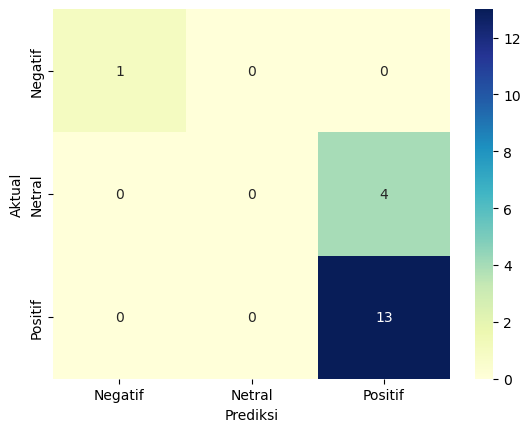

In [27]:
labels = ['Negatif', 'Netral', 'Positif']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
plt.xlabel('Prediksi')
plt.ylabel('Aktual');

# Pengujian Menggunakan Data Baru

In [28]:
def preprocess_data(text):
    lower = lower_cases(text)
    punctuation = remove_punctuation(lower)
    number = remove_numbers(punctuation)
    whitespace = remove_whitespace(number)
    emoji = remove_emojis(whitespace)
    
    words = tokenization(emoji)

    stop_words = set(stopwords.words('indonesian'))
    words = [word for word in words if word not in stop_words]
    
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = ' '.join(stemmed_words)
    
    return text

In [29]:
# Data baru yang akan diprediksi
new_data = [
    "Kurang memadai sebenarnya, masih kurang dalam fasilitas untuk online, seperti mic dan kamera",
    "Ada beberapa dosen yang saya rasa mengajar lebih optimal saat online dan sebaliknya. Dapat terlihat perbedaannya",
    "Suka banget karena bisa pilih mau datang atau dirumah"
]

# Preprocessing pada data baru
new_data_processed = [preprocess_data(text) for text in new_data]

# Transformasi TF-IDF pada data baru
new_data_tfidf = vectorizer.transform(new_data_processed)

# Melakukan prediksi pada data baru
new_data_pred = nb.predict(new_data_tfidf)

# Menampilkan hasil prediksi
for i in range(len(new_data)):
    print("Teks:", new_data[i])
    print("Prediksi Sentimen:", new_data_pred[i])
    print()

Teks: Kurang memadai sebenarnya, masih kurang dalam fasilitas untuk online, seperti mic dan kamera
Prediksi Sentimen: Negatif

Teks: Ada beberapa dosen yang saya rasa mengajar lebih optimal saat online dan sebaliknya. Dapat terlihat perbedaannya
Prediksi Sentimen: Netral

Teks: Suka banget karena bisa pilih mau datang atau dirumah
Prediksi Sentimen: Positif

